In [1]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import os

In [7]:
class torch_reshape(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, 64, 9, 9)

class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.feature_dim = 512

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2), 
            nn.ReLU(True),
            Flatten(),
            nn.Linear(9 * 9 * 64, self.feature_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.feature_dim, 9 * 9 * 64),
            torch_reshape(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, output_padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [62]:
import gym
from tqdm import trange, tqdm
from gym.spaces.box import Box
class TransposeImage(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(TransposeImage, self).__init__(env)
        obs_shape = self.observation_space.shape
        self.observation_space = Box(
            self.observation_space.low[0, 0, 0],
            self.observation_space.high[0, 0, 0],
            [obs_shape[2], obs_shape[1], obs_shape[0]],
            dtype=self.observation_space.dtype)

    def observation(self, observation):
        return observation.transpose(2, 0, 1)

from gym_minigrid.wrappers import *
env = gym.make('MiniGrid-Empty-5x5-v0')
env = RGBImgObsWrapper(env) # Get pixel observations
env = ImgObsWrapper(env) # Get rid of the 'mission' field
env = TransposeImage(env) # Get rid of the 'mission' field
obs = env.reset() # This now produces an RGB tensor only
obs2, _, _, _ = env.step(2)
obs = obs/255; obs2=obs2/255
data_np = np.stack((obs,obs2))
data = torch.Tensor(data_np).cuda()
data.shape

torch.Size([2, 3, 40, 40])

In [72]:
model = autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2,
                             weight_decay=1e-5)
loss_vec = []
num_epochs = 2000
for epoch in tqdm(range(num_epochs)):
    # ===================forward=====================
    output = model(data)
    loss = criterion(output, data)*100

    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # ===================log========================
    loss_vec.append(loss.data.cpu().numpy())
#     if(epoch % 100 == 0):
#         print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.data.cpu().numpy()))

100%|██████████| 2000/2000 [00:05<00:00, 371.10it/s]


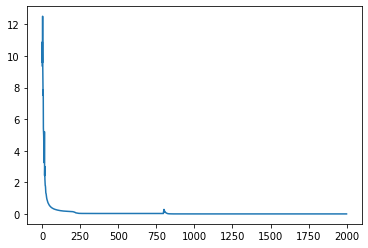

In [73]:
import matplotlib.pyplot as plt
plt.plot(loss_vec)

(3, 40, 40) (3, 40, 40)


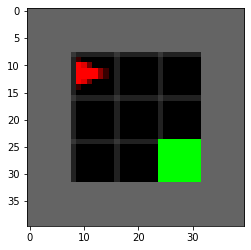

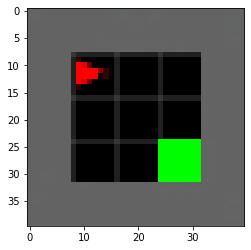

In [74]:
recons = model(data)
recons = recons[0,:,:,:]
re_np = recons.squeeze(0).detach().cpu().numpy()
print(obs.shape, re_np.shape)
plt.imshow(obs.transpose(1,2,0))
plt.show()
plt.imshow(re_np.transpose(1,2,0))